<a href="https://colab.research.google.com/github/tal-yifat/deep-NLP-explainability/blob/main/Primary_task_detecting_long_term_work_absence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [ ]:
# Install required packages
! pip install transformers datasets sentencepiece evaluate torch-lr-finder \
              dataframe_image 
! apt install chromium-chromedriver              

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import evaluate
%matplotlib inline
import time

# Connect to Google Drive for inputs/outputs
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/MSHA_Datasets

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1eOUzsDr6TjqGV_8vuLRBrBZRS5ub9uQ8/MSHA_Datasets


In [ ]:
# Define global constants to configure the experiment 

EXPERIMENT_NAME = 'main-task-clean-version'
PIPELINE_DRY_RUN = False # determines whether the run is just for testing the 
                         # engineering of the notebook
MODEL = r'microsoft/deberta-v3-base'
VAL_RATIO = 0.05 # ratio of validation set
TEST_RATIO = 0.2 # ratio of test set
CLASS_WEIGHT_POWER = 0 # used to control class weight. 0 results in no class 
                       # weights, 1 results in weights that are the inverse of 
                       # the class frequencies, and values in (0, 1) result 
                       # in a value in between. 
OVERSAMPLING_FACTOR = None # for oversampling the minnority class
EPOCHS = 4
LEARNING_RATE = 4.5e-6 # optimal value based on experimentation
WARMUP_STEPS = 500 # based on recommended value for deberta-v3-base
LOG_STEPS = 500
EVAL_STEPS = 5000
RANDOM_SEED = 42
TARGET_THRESHOLD = 90 # the threshold for the length (in days) of predicted 
                      # worker absence

In [ ]:
# Test computational resources and initialize tensorboard
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

timestr = time.strftime('%Y-%m-%d-%H%M')
current_run_logs_dir = MODEL.split('/')[-1] + '_' + EXPERIMENT_NAME + '_' + timestr
tb_writer = SummaryWriter(current_run_logs_dir)

Mon Jan 30 22:49:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Log experiment config

experiment_info = pd.Series({
    'model':MODEL,
    'validatin ratio':VAL_RATIO,
    'test ratio':TEST_RATIO,
    'class weight power':CLASS_WEIGHT_POWER,
    'oversampling factor':OVERSAMPLING_FACTOR,
    'epochs':EPOCHS,
    'learning rate':LEARNING_RATE,
    'warmup steps':WARMUP_STEPS,
    'log_steps':LOG_STEPS,
    'eval_steps':EVAL_STEPS,
    'random_seed':RANDOM_SEED,
    'target threshold':TARGET_THRESHOLD,
    })
experiment_info.to_csv(current_run_logs_dir + '/ExperimentInfo.csv')

# Data exploration and preprocessing

The column DAYS_LOST represents the number of workdays a worker lost due to the injury.

In [ ]:
# Load the data and do basic pre-processing
df = pd.read_csv('accidents.csv')
print ('Total: {}'.format(df.shape[0]))
df = df.dropna(subset = ['DAYS_LOST', 'NARRATIVE'])
print ('Total W/O NA: {}'.format(df.shape[0]))

df = df[['NARRATIVE', 'DAYS_LOST']] 
df = df.reset_index(drop=True)
df.head()

Total: 251956
Total W/O NA: 207641


,NARRATIVE,DAYS_LOST
0,Employee says he slipped off back of fuel truc...,0.0
1,2 employees were attempting to load troughing ...,0.0
2,Employee was pushing against pry bar. Bar slip...,0.0
3,Employee tripped on c-channel at #6 silo. Fel...,0.0
4,Ground was icy. Employee slipped on ice and f...,366.0


In [ ]:
# Replace 'EE' - a commonly used abbreviation - with 'Employee'. 
print('Before replacement:', df['NARRATIVE'].str.count('(^|\s)EE').sum()) 
df['NARRATIVE'] = df['NARRATIVE'].str.replace('(^|\s)EE', 'Employee', case=True, regex=True)
print('After replacement:', df['NARRATIVE'].str.count('(^|\s)EE').sum()) 

Before replacement: 88111
After replacement: 7


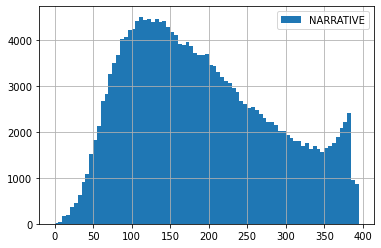

In [ ]:
# Let's check the distribution of narrative lengths
_ = df['NARRATIVE'].str.len().hist(bins=range(0, 400, 5), legend=True)

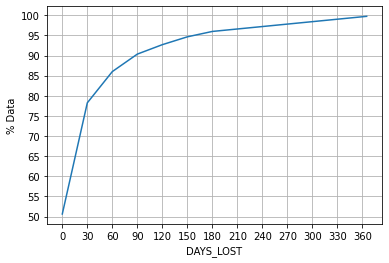

In [ ]:
# Get % of data for different abseince length thresholds
x = [0, 30, 60, 90, 120, 150, 180, 365]
y = [df[df.DAYS_LOST <= i].shape[0] / df.shape[0] * 100 for i in x]
plt.plot(x, y)
plt.xticks(np.arange(min(x), max(x) + 1, 30))
plt.yticks(np.arange(50, 101, 5))
plt.grid()
plt.xlabel("DAYS_LOST")
plt.ylabel("% Data")
plt.show()

In [ ]:
# Binarize the label
df = df.rename(columns={'NARRATIVE': 'text', 'DAYS_LOST': 'label'})
df['label'] = np.where((df['label'] > TARGET_THRESHOLD), 1, 0) 
df.head()

,text,label
0,Employee says he slipped off back of fuel truc...,0
1,2 employees were attempting to load troughing ...,0
2,Employee was pushing against pry bar. Bar slip...,0
3,Employee tripped on c-channel at #6 silo. Fel...,0
4,Ground was icy. Employee slipped on ice and f...,1


In [ ]:
# Splint into train, test and validation

from sklearn.model_selection import train_test_split

if PIPELINE_DRY_RUN: 
  df = df.head(100)
  VAL_RATIO = 0.2
  LOG_STEPS = 5
  EVAL_STEPS = 5

df_train, df_test, df_train['label'], df_test['label'] = train_test_split(df[['text']], df['label'], 
                                                    test_size=TEST_RATIO, random_state=RANDOM_SEED)
df_train, df_val, df_train['label'], df_val['label'] = train_test_split(df_train[['text']], df_train['label'], 
                                                    test_size=VAL_RATIO / (1 - TEST_RATIO), random_state=RANDOM_SEED)
# Verifying there's no overlap between the sets
assert(set(df_train.index).intersection(df_val.index)==set())
assert(set(df_train.index).intersection(df_test.index)==set())
assert(set(df_val.index).intersection(df_test.index)==set())

print(df_train.shape, df_val.shape, df_test.shape)

(155730, 2) (10382, 2) (41529, 2)


In [ ]:
# Implements oversampleing, depending on the experiment configuration
if OVERSAMPLING_FACTOR:
  df_oversample = pd.DataFrame(np.repeat(df_train[df_train['label']==1].values, 
                                        OVERSAMPLING_FACTOR-1, 
                                        axis=0),
                              columns=df_train.columns)
  df_train = df_train.append(df_oversample).sample(frac=1, random_state=RANDOM_SEED)
  df_train.shape

In [ ]:
import datasets
from datasets import Dataset, DatasetDict, ClassLabel

train_ds = Dataset.from_pandas(df_train, split='train')
train_ds.features['label'] = ClassLabel(num_classes=2, names=['<90', '>=90'])
val_ds = Dataset.from_pandas(df_val, split='val')
val_ds.features['label'] = ClassLabel(num_classes=2, names=['<90', '>=90'])
test_ds = Dataset.from_pandas(df_test, split='test')
test_ds.features['label'] = ClassLabel(num_classes=2, names=['<90', '>=90'])
raw_datasets = DatasetDict()
raw_datasets['train'] = train_ds
raw_datasets['validation'] = val_ds
raw_datasets['test'] = test_ds
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 155730
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 10382
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 41529
    })
})

# Tokenization

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(sample):
    return tokenizer(sample['text'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/156 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/42 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 155730
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10382
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 41529
    })
})

In [ ]:
from tabulate import tabulate
from tqdm import trange
import random

def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(tokenized_datasets['train']['text'])-1)
  table = np.array([tokenizer.tokenize(tokenized_datasets['train']['text'][index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(
                        tokenized_datasets['train']['text'][index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒════════════════╤═════════════╕
│ Tokens         │   Token IDs │
╞════════════════╪═════════════╡
│ ▁On            │         589 │
├────────────────┼─────────────┤
│ ▁9             │         712 │
├────────────────┼─────────────┤
│ /              │         320 │
├────────────────┼─────────────┤
│ 16             │        1984 │
├────────────────┼─────────────┤
│ /              │         320 │
├────────────────┼─────────────┤
│ 21             │        2917 │
├────────────────┼─────────────┤
│ ,              │         261 │
├────────────────┼─────────────┤
│ ▁Employee      │       15676 │
├────────────────┼─────────────┤
│ ▁was           │         284 │
├────────────────┼─────────────┤
│ ▁disassembling │      108293 │
├────────────────┼─────────────┤
│ ▁a             │         266 │
├────────────────┼─────────────┤
│ ▁turning       │        3104 │
├────────────────┼─────────────┤
│ ▁motor         │        3434 │
├────────────────┼─────────────┤
│ ▁on            │         277 │
├─────────

# Model training

In [ ]:
# Metrics to compute during evaluation

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def compute_metrics(eval_preds):
    clf_metrics = evaluate.combine(['accuracy', 'f1', 'precision', 'recall'])
    roc_auc = evaluate.load('roc_auc')
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    class_1_pred_probs = [sigmoid(p1) for p0, p1 in logits]
    metric_res = roc_auc.compute(prediction_scores=class_1_pred_probs, references=labels)
    metric_res.update(clf_metrics.compute(predictions=predictions, references=labels))

    return metric_res

In [ ]:

from transformers import Trainer

val_counts = df_train['label'].value_counts()
class_freqs = (val_counts[0] / df_train.shape[0] , val_counts[1] / df_train.shape[0])
print('Class freqs: ', class_freqs)
class_weights = [(1/frq) ** CLASS_WEIGHT_POWER for frq in class_freqs]
print('class weights before normalization: ', class_weights)

# Normalize the class weights so that the mean weight for the dataset is 1,
# in order to avoid impacting the learning rate. 
loss_normalizer = 1 / (class_freqs[0] * class_weights[0] + class_freqs[1] * class_weights[1])
NORM_CLASS_WEIGHTS = [float(wt * loss_normalizer) for wt in class_weights]

print('Class weights after normalization: ', NORM_CLASS_WEIGHTS)

class CustomTrainer(Trainer):
    def __repr__(self):
      return super().__repr__() 
    
    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # inputs.to(device)
        labels = inputs.get('labels')
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(NORM_CLASS_WEIGHTS).to(device))
        # loss_fct = torch.nn.BCELoss(weight=torch.tensor(NORM_CLASS_WEIGHTS).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

class freqs:  (0.9033647980479034, 0.09663520195209657)
class weights before normalization:  [1.0, 1.0]
Class weights after normalization:  [1.0, 1.0]


In [ ]:
from transformers import TrainingArguments, AutoModelForSequenceClassification
from transformers import Trainer
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(output_dir=current_run_logs_dir, 
                                  learning_rate=LEARNING_RATE,
                                  warmup_steps=WARMUP_STEPS,
                                  evaluation_strategy='steps',
                                  logging_steps=LOG_STEPS,
                                  eval_steps=EVAL_STEPS,
                                  save_strategy='epoch', 
                                  num_train_epochs=EPOCHS,
                                  report_to='tensorboard')
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[TensorBoardCallback(tb_writer=tb_writer)]
) 

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

In [ ]:
trainer.train()    

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 155730
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 77868
  Number of trainable parameters = 184423682
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, us

Step,Training Loss,Validation Loss,Roc Auc,Accuracy,F1,Precision,Recall
5000,0.317400,0.306661,0.761109,0.902813,0.000000,0.000000,0.000000
10000,0.306400,0.319959,0.775156,0.902813,0.000000,0.000000,0.000000
15000,0.302200,0.324517,0.778470,0.902813,0.000000,0.000000,0.000000
20000,0.285800,0.356053,0.765666,0.903005,0.075298,0.512500,0.040634
25000,0.310000,0.343691,0.782082,0.898574,0.109890,0.373563,0.064420
30000,0.287500,0.349998,0.782852,0.903005,0.007882,0.666667,0.003964
35000,0.302300,0.324831,0.789058,0.903198,0.034582,0.562500,0.017839
40000,0.303700,0.310533,0.789677,0.899923,0.112724,0.407407,0.065411
45000,0.280300,0.339727,0.786515,0.902331,0.074818,0.471264,0.040634
50000,0.287400,0.324732,0.790122,0.898093,0.160317,0.402390,0.100099


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10382
  Batch size = 8
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation **

TrainOutput(global_step=77868, training_loss=0.2984453169842827, metrics={'train_runtime': 18245.0203, 'train_samples_per_second': 34.142, 'train_steps_per_second': 4.268, 'total_flos': 2.4762310606330944e+16, 'train_loss': 0.2984453169842827, 'epoch': 4.0})

In [ ]:
test_res = trainer.evaluate(eval_dataset=tokenized_datasets['test'], metric_key_prefix='test')
pd.Series(test_res).to_csv(current_run_logs_dir + '/TestResults.csv')
test_res

The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 41529
  Batch size = 8


{'test_loss': 0.3256658911705017,
 'test_roc_auc': 0.7966282463859876,
 'test_accuracy': 0.8985768980712273,
 'test_f1': 0.17894736842105263,
 'test_precision': 0.3984375,
 'test_recall': 0.11538461538461539,
 'test_runtime': 285.4609,
 'test_samples_per_second': 145.481,
 'test_steps_per_second': 18.188,
 'epoch': 4.0}

In [ ]:
# Generating more evaluation outputs

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import dataframe_image as dfi

logits, true_labels, _ = trainer.predict(tokenized_datasets['test'])
predictions = np.argmax(logits, axis=-1)
class_1_pred_probs = [sigmoid(p1) for p0, p1 in logits]
    
print(classification_report(true_labels, predictions))
cl_report = classification_report(true_labels, predictions, output_dict=True)
df_cl_report = pd.DataFrame(cl_report).transpose()
cm_report = confusion_matrix(true_labels, predictions)
df = pd.DataFrame(cm_report).transpose()
df_cm_report = pd.DataFrame(cm_report, index=['True Negative', 'True Positive'],
                  columns=['Predicted Negative', 'Predicted Positive'])
print('Confusion Matrix\n', df_cm_report)

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 41529
  Batch size = 8


              precision    recall  f1-score   support

           0       0.91      0.98      0.95     37551
           1       0.40      0.12      0.18      3978

    accuracy                           0.90     41529
   macro avg       0.66      0.55      0.56     41529
weighted avg       0.86      0.90      0.87     41529

Confusion Matrix
                Predicted Negative  Predicted Positive
True Negative               36858                 693
True Positive                3519                 459


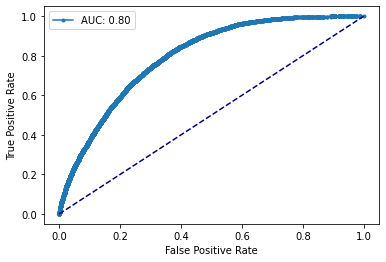

In [ ]:
# plot the roc curve for the model

from sklearn.metrics import roc_curve
from matplotlib import pyplot

aucpath = current_run_logs_dir + "/auc_roc_plot.png"

auc = roc_auc_score(true_labels, class_1_pred_probs)
auc = round(auc, 2)
br_fpr, br_tpr, _ = roc_curve(true_labels, class_1_pred_probs, pos_label=1)
pyplot.plot(br_fpr, br_tpr, marker='.', label=('AUC: %.2f' % auc))
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.savefig(aucpath)
pyplot.show()

In [ ]:
if not PIPELINE_DRY_RUN:
  model_save_name = 'bert_injuries_model.pt'
  path = current_run_logs_dir + '/' + model_save_name
  torch.save(model.state_dict(), path)


In [ ]:
tbpath = current_run_logs_dir
%tensorboard --logdir $tbpath
nb_path =  current_run_logs_dir + '/Saved_Bert_Injuries.ipynb'
%notebook $nb_path

<IPython.core.display.Javascript object>

In [ ]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=5000,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_n

In [ ]:
model

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 